## Select articles: look for hateful comments

In [39]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-selection")
db = client["hatespeech-selection"]

Article.objects.count()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


68896

Acá tomamos a partir del 1ro de marzo...

In [40]:
import datetime

start_date = datetime.datetime(2020, 3, 1)

base_query = {
    "dummy__ne": True,
    "comments__19__exists": True,
    "created_at__gte": start_date,
}

Article.objects(**base_query).count()

10314

In [41]:
import random
from mongoengine import DoesNotExist
from hatespeech_models import Reply
from collections import defaultdict

comment_seeds = [
    # Mujer
    "bija",
    "\"prostituta\"",
    #"\"trola\"",
    
    "feministas",
    "feminazis",
    "aborteras",
    "\"boluda\"",
    "\"botox\"",
    #"\"puta\"",
    #"\"gato\"",
    "\"urraca\"",
    "tucán",
    # LGBTI
    "marica",
    "\"viejo puto\"",    
    "\"trabuco\"",
    "travesti",
    "\"degenerado\"",
    #"\"puto\"",
    "trolo -\"no seas\" -\"no sean\"",
    "\"sodomita\"",
    
    # Xenofobia, Racismo, Religión
    "chinos",
    "\"sucios\"",
    "bolita",
    # Lo pongo así porque "Paraguay" lo usan contra macri
    "\"paraguayo\"",
    "\"peruano\"",
    "\"peruca\"",
    "judío",
    
    "\"jude\"",
    "sionista",
    "\"matarlos\"",
    "\"una bomba\"",
    
    # Pobreza
    
    #"\"vagos\"",
    "\"vayan a laburar\"",
    "\"vayan a trabajar\"",
    #"\"negros de mierda\"",
    #"\"negro de mierda\"",
    #"\"negra de mierda\"",
    "\"villeros\"",
    #"\"negro\" \"hdp\"",
    "negro -\"en negro\"",
    #parásitos
    # Política
    #"\"terrorista\"",
    
    # Violentos
    "\"bala\"",

    "\"uno menos\"",
    # Aspecto
    "\"gorda\"",
]

new_article_ids = set()

votes = defaultdict(list)
reason = {}
seed_articles = {}

for word in comment_seeds:
    nuevos = 0
    limit = None
    if type(word) is tuple:
        word, limit = word
    """
    for _ in range(3):
        print("="*80)
        
    print(f"\n\n{word}\n\n")
    """
    replies = Reply.objects.no_dereference().search_text(word)
    article_ids = [rep.article.id for rep in replies]
    articles = Article.objects(id__in=article_ids, **base_query)
    total_count = articles.count()
    
    for rep in replies:
        votes[rep.article.id].append(word)
    
    for article in articles:
        try:
            if article.id not in seed_articles:
                nuevos += 1
                seed_articles[article.id] = article
                reason[article.id] = f"Comment -- {word} ({word})"
                if limit and nuevos >= limit:
                    break
            else:
                pass
                #print(f"\nSkipping {article} -- Reason: {reason[article.id]}")
        except DoesNotExist as e:
            pass
            #print(f"\nSkipping {Article.objects.get(id=rep.article.id)} -- {e}")

    print(f"{word:<30} ---> {len(seed_articles):<5}, {nuevos:<4} nuevos/ {total_count:<5} total", end="")
    
    if limit:
        print(f" (limitados a {limit})")
    else:
        print("")


bija                           ---> 47   , 47   nuevos/ 47    total
"prostituta"                   ---> 193  , 146  nuevos/ 148   total
feministas                     ---> 463  , 270  nuevos/ 301   total
feminazis                      ---> 509  , 46   nuevos/ 86    total
aborteras                      ---> 619  , 110  nuevos/ 159   total
"boluda"                       ---> 1221 , 602  nuevos/ 783   total
"botox"                        ---> 1259 , 38   nuevos/ 69    total
"urraca"                       ---> 1296 , 37   nuevos/ 65    total
tucán                          ---> 1355 , 59   nuevos/ 96    total
marica                         ---> 1405 , 50   nuevos/ 69    total
"viejo puto"                   ---> 1455 , 50   nuevos/ 67    total
"trabuco"                      ---> 1457 , 2    nuevos/ 8     total
travesti                       ---> 1486 , 29   nuevos/ 44    total
"degenerado"                   ---> 1616 , 130  nuevos/ 211   total
trolo -"no seas" -"no sean"    ---> 1831 , 215  

Los jevis:
- "negro mierda"
- "chinos"
- "paraguayo"


In [42]:
len(seed_articles)

4938

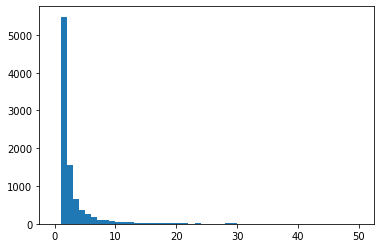

In [43]:
import matplotlib.pyplot as plt

plt.hist([len(v) for v in votes.values()], bins=50, range=[0, 50]);


Me quedo sólo con los artículos que tengan al menos 2 votos

In [44]:
selected_articles = {k: v for k, v in votes.items() if len(v) >= 2}
selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)

selected_articles.count()

2832

Les pongo la descripción de su elección

In [45]:
Article.objects.update(set__description="")

68896

In [46]:
from tqdm.auto import tqdm
from collections import Counter

for article in tqdm(selected_articles):
    this_art_votes = votes[article.id]
    
    article.description = str(dict(Counter(this_art_votes)))
    article.save()

In [47]:
selected_articles[0].id

ObjectId('5ee5a2806d0165dcb3ab5603')

In [48]:
from groups.models import Group

def accept_article(art):
    politicians = ["Ginés", "Mauricio Macri", "Alberto Fernández", "Magario"]
    
    if any(p.lower() in art.title.lower() for p in politicians):
        return len(votes[art.id]) >= 5
    return True
    
    
for k in [2, 3, 4, 5]:
    try:
        group = Group.objects.get(name=f"Seed comments - {k} votes")
    except DoesNotExist:
        group = Group(name=f"Seed comments - {k} votes")
    selected_articles = {article_id: v for article_id, v in votes.items() if len(v) >= k}
    selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)
    selected_articles = [a for a in selected_articles if accept_article(a)]
    print(f"{k} votes -- {len(selected_articles)} articles")
    group.articles = selected_articles
    
    group.save()
    


2 votes -- 2576 articles
3 votes -- 1711 articles
4 votes -- 1288 articles
5 votes -- 1035 articles


In [49]:
group = Group.objects.no_dereference().get(name="Seed comments - 3 votes")

In [50]:
article_ids = [a.id for a in group.articles]
Article.objects.update(set__selected=False)
updated = Article.objects(id__in=article_ids).update(set__selected=True)
print(f"Marcados como seleccionados {updated} artículos")

Marcados como seleccionados 1711 artículos


In [51]:
Reply.objects.search_text("\"negro\" -\"en negro\"").count()

3163

In [25]:
for r in Reply.objects.search_text("\"negro\" -\"en negro\""):
    print("="*80)
    print(r.article.title, "\n"*2)
    #print(r.text)

¿Terminará Argentina como Venezuela? 


Susana Giménez recibió el alta luego de haber sido internada en Punta del Este por un accidente doméstico 


LeBron James, furioso por el asesinato de un afroamericano tras la violencia policial: “¡Despierten!” 


Alerta en el conurbano: crecen los casos de COVID-19 en barrios populares y reforzarán los controles sanitarios 


Por el coronavirus, suspenden la audiencia del juicio contra Cristina Kirchner 


Marcha 26A: hubo protestas en algunas esquinas barriales pero el aguacero dispersó a los manifestantes 


El PAMI tendrá que pagar una cirugía para agrandar los pechos de una afiliada autopercibida mujer 


Patricia Bullrich dijo que no convocan a la marcha del lunes, pero que “99% de los adherentes al PRO sienten que deben estar ahí” 


Coronavirus en la Argentina: denuncian consorcios ante la Justicia por los escraches a los médicos 


Dady Brieva, sobre el peronismo: “Tenemos que instalarnos y nunca más irnos” 


Ginés González García: “Qui

In [14]:
from pprint import pprint as pp

for j, art in enumerate(selected_articles):
    print(f"{j:<5} -- {art.title}")
    print("\n")
    pp(art.first_paragraphs)
    print(f"Razón: {reason[art.id]}")
    
    comments = random.sample(art.comments, 10)
    
    for repl in comments:
        print(repl.text)
    print("\n\n")

0     -- Activaron el protocolo de coronavirus en Ezeiza por un pasajero que llegó desde EEUU, pero descartaron que sea positivo


('Este es el avión de American Airlines al que le activaron el protocolo de '
 'coronavirus en Ezeiza (Gustavo Gavotti)\n'
 '\n'
 'Personal sanitario del aeropuerto de Ezeiza tuvo que activar este lunes por '
 'la mañana el protocolo de emergencia por coronavirus a bordo de una avión '
 'procedente de Nueva York debido a que uno de los pasajeros presentaba '
 'fiebre. Pero tras hacerle los controles sanitarios pertinentes descartaron '
 'que sea portador de la enfermedad.\n'
 '\n'
 'El vuelo 953 de American Airlines aterrizó en Buenos Aires a las 10:45 y '
 'antes de hacer descender a las personas que estaban a bordo, el comandante '
 'informó que se había activado el protocolo para asistir a una persona que se '
 'sentía mal. El resto de los pasajeros, en tanto, tuvo que permanecer en sus '
 'lugares a la espera de una autorización para descender del avión

KeyboardInterrupt: 